In [0]:
import tensorflow as tf
import keras
from keras.layers import Dense
import numpy as np
import numpy.random as random
import pylab as plt
import sklearn
import sklearn.linear_model
import IPython.display
import time
tf.enable_eager_execution()
%matplotlib inline
np.random.seed(3)
tf.set_random_seed(5)
import os

from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


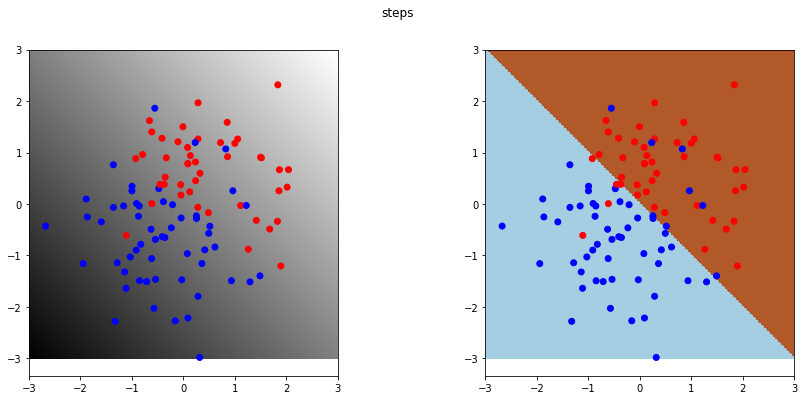

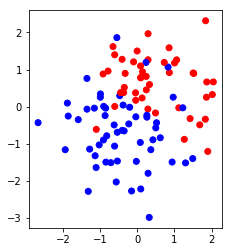

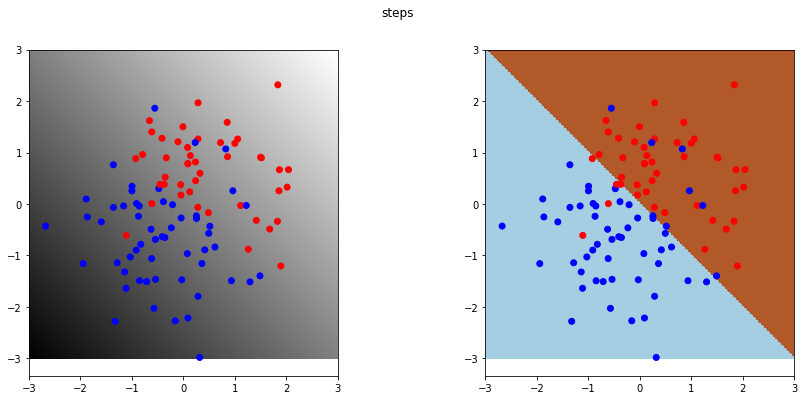

In [0]:
def make_data(n, p = 0.1):
  X = random.randn(n, 2)
  w = random.randn(2)
  Y_clean = np.sign(X.dot(w))
  Y = Y_clean * np.sign(random.rand(n) - p)
  return X, Y, Y_clean

def make_data_sep(n, p = 0.1):
  theta = random.randn(2)
  theta = theta / np.linalg.norm(theta)
  X1 = 0.2*random.randn(n//2, 2) + theta
  X2 = 0.2*random.randn(n//2, 2) - theta
  X = np.r_[X1, X2]
  random.shuffle(X)
  Y_clean = np.sign(X.dot(theta))
  Y = Y_clean * np.sign(random.rand(n) - p)
  return X, Y

N = 100
X, Y, Y_clean = make_data(N, p=0.05)  #make_data_sep(N, p=0.05)
plt.scatter(X[:,0], X[:,1], c=Y, cmap='bwr')
plt.axes().set_aspect('equal')


def plot_func(func, X, Y):
  XX, YY = np.mgrid[-3:3:200j, -3:3:200j]
  pts = np.c_[XX.ravel(), YY.ravel()]

  F = func(pts).reshape(XX.shape)

  fig = plt.figure(figsize=(15, 6))
  ax = plt.subplot(121)
  plt.pcolormesh(XX, YY, F.reshape(XX.shape), cmap='gray')
  plt.scatter(X[:,0], X[:,1], c=Y, cmap='bwr')
  ax.set_aspect('equal')

  ax = plt.subplot(122)
  plt.pcolormesh(XX, YY, F.reshape(XX.shape) > 0, cmap=plt.cm.Paired)
  plt.scatter(X[:,0], X[:,1], c=Y, cmap='bwr')
  ax.set_aspect('equal')
  
  fig.suptitle('steps')
  return fig
  

plot_func(lambda pts: np.apply_along_axis(lambda p: p[0] + p[1], 1 , pts), X, Y)

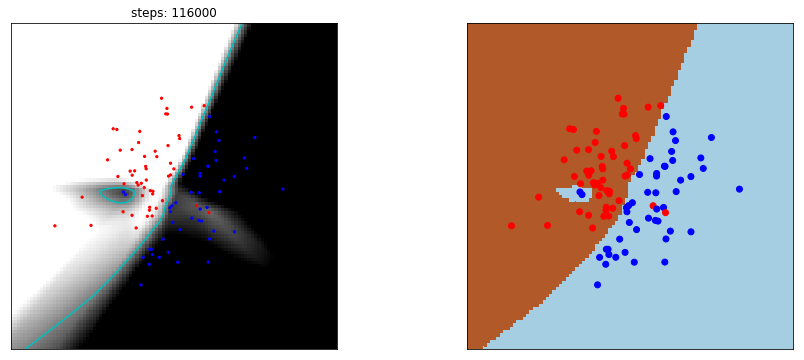

steps:  116000
epoch:  116000 loss:  0.033224747 ||batch-grad_W0||_2:  0.0056728804


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f1e9218cc80> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
class FNN(tf.keras.Model):
  def __init__(self):
    super(FNN, self).__init__()
    #self.D1 = Dense(100, activation='relu',input_shape=[2])
    self.D1 = Dense(100, activation='relu', input_shape=[2],
                    kernel_initializer = keras.initializers.random_normal(stddev = 1.0/np.sqrt(2)),
                    bias_initializer = keras.initializers.random_normal(1.0))
    self.D2 = Dense(100, activation='relu',
                    kernel_initializer = keras.initializers.random_normal(stddev = 1.0/np.sqrt(100)))
                    #bias_initializer = keras.initializers.random_normal(1.0))
    self.out = Dense(1, activation=None,
                    kernel_initializer = keras.initializers.random_normal(stddev = 1.0/np.sqrt(100)))
  
  def call(self, x):
    x = self.D1(x)
    x = self.D2(x)
    return self.out(x)

 
def hinge(z):
  all_ones = tf.ones_like(z)
  return tf.nn.relu(tf.subtract(all_ones, z))

plot_model = lambda model: plot_func(model.predict, X, Y)



X_train = tf.convert_to_tensor(X, dtype=tf.float32)
Y_train = tf.expand_dims(tf.convert_to_tensor(Y, dtype=tf.float32), 1)

XX, YY = np.mgrid[-4:4:100j, -4:4:100j] # grid for plotting
pts = np.c_[XX.ravel(), YY.ravel()]
fig = None

model = FNN()
learning_rate=0.001
batch_size = N

steps = 0
model(X_train[0:1, :]) # just evaluate it once so things get initialized

SAVE = True
path = '/content/gdrive/My Drive/G/ML/Experiments/Anim_HingeLoss2_t%d/' % (int(time.time()))
if SAVE:
  os.makedirs(path)
  with open(path + 'README.txt', 'w') as f:
    f.write("""N=%d
    p=0.05
    Architecture: 2-layers, 100-100
    Loss: MSE
    Training: SGD, learning-rate %f
    """ % (N, learning_rate))

for epoch in range(1000000):
  
  batches = N // batch_size
  for b in range(batches):
    Xi = X_train[b*batch_size:(b+1)*batch_size, :]
    Yi = Y_train[b*batch_size:(b+1)*batch_size]
    
    # fig = plot_model(model)
    # Plotting
    #
    
    if steps < 50 or (steps < 1000 and steps % 50 == 0) or steps % 1000 == 0:
      IPython.display.clear_output(wait=True)

      F = model.predict(pts).reshape(XX.shape)
      #plt.imshow(F)

      if fig is not None:
        plt.close(fig)
        
      fig = plt.figure(figsize=(15, 6))
      ax = plt.subplot(121)
      plt.pcolormesh(XX, YY, F.reshape(XX.shape), vmin=-2, vmax=+2, cmap='gray')
      plt.contour(XX, YY, F, levels=[0], colors='c')
      plt.scatter(X[:,0], X[:,1], c=Y, cmap='bwr', s=5.0)
      ax.set_yticks([])
      ax.set_xticks([])
      
      ax.set_title('steps: ' + str(steps))

      if batch_size == 1:
        plt.scatter([X[b,0]], [X[b,1]], c= ('b' if Y[b]==-1 else 'r'), s=50.0)

      ax.set_aspect('equal')

      ax = plt.subplot(122)
      ax.pcolormesh(XX, YY, F.reshape(XX.shape) > 0, cmap=plt.cm.Paired)
      plt.scatter(X[:,0], X[:,1], c=Y, cmap='bwr')
      ax.set_aspect('equal')
      ax.set_yticks([])
      ax.set_xticks([])
      
      
      if SAVE:
        fname = path + ('step%08d' % steps)
        plt.savefig(fname)
  
      IPython.display.display(plt.gcf())

      print('steps: ', steps)
    #
    # End ploting
    
    

    
    
    
    

    
    with tf.GradientTape() as tape:
      pred = model(Xi)
      #loss_val = tf.reduce_mean(tf.square(Yi - pred)) # MSE
      loss_val = tf.reduce_mean(hinge(tf.multiply(pred, Yi))) # hinge loss
      

    grad = tape.gradient(loss_val, model.trainable_variables)
    
    
    for g, w in zip(grad, model.trainable_variables):
      w.assign_sub(learning_rate * g)
      #w.assign_sub(learning_rate * (g + tf.random_normal(g.shape, stddev=0.0001)))
    
    
    steps += 1


    
  if epoch % 100 == 0:
    print('epoch: ', epoch, 'loss: ', loss_val.numpy(), '||batch-grad_W0||_2: ', np.linalg.norm(grad[0].numpy()))
    

  
#plot_model(model, X, Y)


In [0]:
error = np.sum(Y != np.sign(model.predict(X).flatten()))
print(error) # num of mis-predictions

16


Instructions for updating:
Colocations handled automatically by placer.


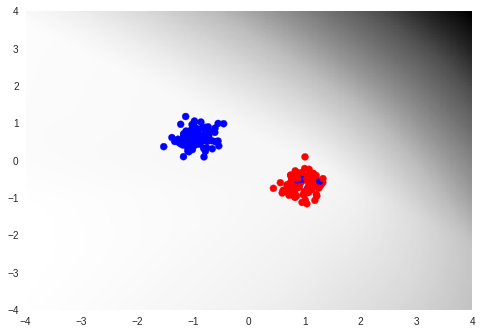

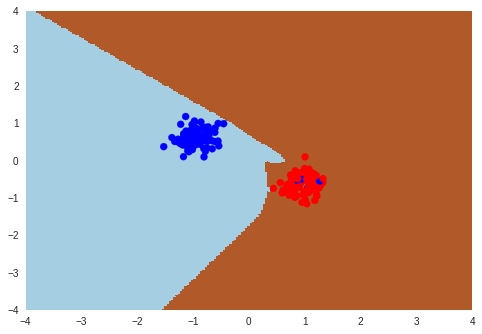

In [0]:
plot_model(model, X, Y)

In [0]:
Y[0]

1.0

In [0]:
Y_train-pred

<tf.Tensor: id=58199, shape=(10, 1), dtype=float32, numpy=
array([[ 0.8911078 ],
       [ 0.6605425 ],
       [ 0.51712674],
       [ 0.091766  ],
       [ 0.5648165 ],
       [ 1.3036222 ],
       [-0.8394245 ],
       [-1.1766994 ],
       [-0.86588305],
       [-0.7353184 ]], dtype=float32)>

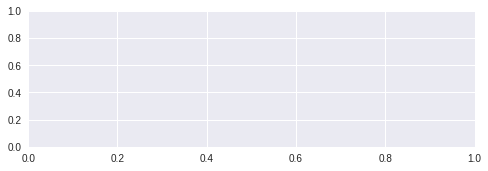

In [0]:
ax = plt.subplot(211)

In [0]:
time.sleep(1)